In [1]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB as MNB, GaussianNB as GNB, BernoulliNB as BNB
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve, auc, mean_squared_error, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import SGDClassifier as SGD
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator
from sklearn.grid_search import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

//anaconda/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/envs/py35/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
import operator

from nltk import collocations
import nltk 

from collections import defaultdict
from gensim.models import word2vec

import xgboost as xgb

In [3]:
import gensim
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec

### 1. Загрузка данных

#### 1.1. Сырые данные

In [5]:
RAW_DATA_FILE = '../ram_train.csv'

In [6]:
data = pd.read_csv(RAW_DATA_FILE)

In [7]:
data.head(5)

uid  time                                              title  age  sex
0  112942     0  Рамблер/почта – надежная и бесплатная электрон...    5    0
1  111499     0  Россия ответила на претензии США по размещению...    3    1
2  237186     0  Вести.Ru: Останки убитой девочки родители разб...    3    0
3  265356     1  Работа, вакансии, база резюме, поиск работы на...    3    1
4  240286     1  Севилья – Барселона 14 августа 2016, воскресен...    3    1

#### 1.2. Предобработанные данные. Проведена токенезация, нормализация(леммитизация), удалены стоп слова

In [8]:
def load_batches(n):
    df_batches = pd.DataFrame()
    for i in range(n):
        data = pd.read_csv("../batch/batch_{0}.csv".format(i), index_col=0)
        df_batches = pd.concat([df_batches, data], ignore_index=True)
    return df_batches

In [9]:
data_norm = load_batches(287)

In [10]:
users =  data[['uid', 'age', 'sex']].groupby('uid').mean()
users = np.round(users)

In [11]:
ndata = data_norm.join(users, on = ['uid'], how = 'left')

#### 1.3. Объединяем пользователей. Учитываем истоию пользователей в совокупности

In [12]:
if ndata.isnull().values.sum() > 0:
    print("Number of null values: {0}".format(ndata.isnull().values.sum()))
    df = ndata.dropna()

Number of null values: 4741


In [13]:
def join_user_with_same_uid(users):### Умная функций для склейки, учитывает предыдущие запросы.
    return pd.Series(data=(users.uid.values[0], ". ".join(users.title.unique()), users.sex.values[0], users.age.values[0]), index=['uid', 'title', 'sex', 'age'])

In [14]:
udata = df.groupby('uid').apply(join_user_with_same_uid)

In [15]:
print("Количество пользователей: {0}".format(udata.shape[0]))

Количество пользователей: 299996


### 2. Анализ данных

#### 2.1. Пол

In [16]:
udata.sex.value_counts()

1.0    183015
0.0    116981
Name: sex, dtype: int64

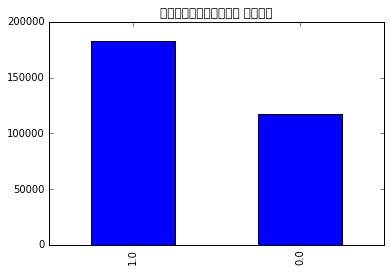

In [17]:
udata.sex.value_counts().plot(kind='bar', title="Гистограмма пола")

#### 2.2. Возраст

In [16]:
udata.age.value_counts()

3.0    94170
4.0    82116
5.0    55011
6.0    27900
2.0    24276
7.0    10334
1.0     6189
Name: age, dtype: int64

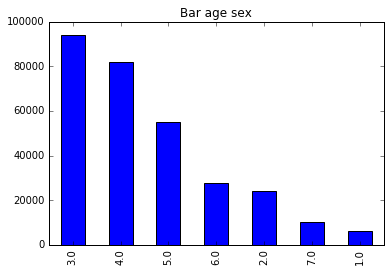

In [17]:
udata.age.value_counts().plot(kind='bar', title="Bar age sex")

#### 2.3. Текст

#### 2.3.1 Так как стартовые страницы для каждого из пользователей, внезависмости от пола и возраста могут быть одинаковыми - необходимо их выкинуть так как они не влияют на определение пола и возраста,  а лишь зашумляют данные. 

In [14]:
df.title.value_counts()[0:5000]

рамблер медийный портал                                                                                                                                 4937039
рамблер почта надёжный бесплатный электронный почта                                                                                                     4233091
рамблер                                                                                                                                                  397819
lenta ru                                                                                                                                                 214633
чемпионат com новость спорт чемпионат                                                                                                                    188589
рамблер новость                                                                                                                                          187114
главный рамблер новость                 

#### Рассмотрим 1-ые 10-ть часто посещаемых сайтов.

In [16]:
most_freq_title_list = df.title.value_counts()[0:10]

In [17]:
for title in most_freq_title_list.keys():
    print("Заголвок:{0}".format(title))
    print(df[df.title == title]['sex'].value_counts())
    print(df[df.title == title]['age'].value_counts())

Заголвок:рамблер медийный портал
1.0    3416762
0.0    1520277
Name: sex, dtype: int64
4.0    1466486
5.0    1190556
3.0    1085315
6.0     683245
7.0     265401
2.0     171231
1.0      74805
Name: age, dtype: int64
Заголвок:рамблер почта надёжный бесплатный электронный почта
1.0    2542392
0.0    1690699
Name: sex, dtype: int64
4.0    1196323
3.0    1167684
5.0     885552
6.0     465793
2.0     258872
7.0     177973
1.0      80894
Name: age, dtype: int64
Заголвок:рамблер
1.0    294283
0.0    103536
Name: sex, dtype: int64
5.0    122469
4.0    113398
6.0     74024
3.0     48555
7.0     26023
1.0      6712
2.0      6638
Name: age, dtype: int64
Заголвок:lenta ru
1.0    179502
0.0     35131
Name: sex, dtype: int64
3.0    73991
4.0    62619
5.0    36992
6.0    17450
2.0    11199
7.0     8907
1.0     3475
Name: age, dtype: int64
Заголвок:чемпионат com новость спорт чемпионат
1.0    167991
0.0     20598
Name: sex, dtype: int64
3.0    76436
4.0    42409
5.0    25283
2.0    21031
6.0    14914


#### Гипотеза подтвердилась. Удалим ненужные  данные из выборки.

In [18]:
clear_most_freq_title_list = df.title.value_counts()[0:5000]

In [19]:
clear_most_freq_title_list.tail(10)

беляков завоевать россия бронза бокс вес килограмм рамблер новость                                     355
coral travel ukraine                                                                                   355
автошкола смочь самостоятельно принимать экзамен водительский право законодательство журнал quto ru    355
прыгунья длина дарья клишина выйти финал олимпиада ои спорт lenta ru                                   355
тасс политика ольга васильев известно новый министр образование                                        355
индийский актриса яплакалъ                                                                             355
блог футбол динамо киев шурик                                                                          355
живой лежачий полицейский рамблер видео                                                                354
жилищный кодекс российский федерация n фз ред консультантплюс                                          354
pitermeteo ru погода санкт петербург 

In [20]:
clear_df = df[~df['title'].isin(clear_most_freq_title_list.head(5000).index)]

In [21]:
print("Объем данных сократился в {0:2f}".format(df.shape[0] / clear_df.shape[0]))

Объем данных сократился в 2.826289


In [22]:
cdata = clear_df.groupby('uid').apply(join_user_with_same_uid)

In [23]:
print("Количество пользователей: {0}".format(cdata.shape[0]))

Количество пользователей: 281954


#### 2.3.2 Для такого чтобы с текстом проводить какие-нибудь операции, необходимо векторизовать текст. Применим подход TF-IDF. И найдем какие слова встречаются чаще всего в тексте

In [24]:
X = cdata.title
vectorizer = TfidfVectorizer().fit(X)
tf_idf_train = vectorizer.transform(X)

In [25]:
tf_idf_dict = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

In [26]:
dict_freq_words = sorted(tf_idf_dict.items(), key=operator.itemgetter(1))
freq_words = list(map(lambda x: x[0], dict_freq_words))[0:100]
dict_freq_words

[('ru', 1.5188972195220947),
 ('новость', 1.7863712612847724),
 ('рамблер', 1.8371118737889445),
 ('россия', 1.972907904192986),
 ('москва', 2.2121695472045646),
 ('год', 2.224595047087413),
 ('весь', 2.3167013375559184),
 ('фото', 2.3233531143076425),
 ('российский', 2.374570690741729),
 ('видео', 2.4867626135466514),
 ('купить', 2.4988508809324022),
 ('онлайн', 2.5373865862390792),
 ('цена', 2.5656687303214603),
 ('день', 2.6077192575226227),
 ('интернет', 2.608640230985757),
 ('новый', 2.6312012839499612),
 ('олимпиада', 2.6339416829318063),
 ('поиск', 2.6476837679723131),
 ('сайт', 2.6614118381264351),
 ('самый', 2.6826500709225938),
 ('магазин', 2.692987616592549),
 ('ру', 2.722232612550227),
 ('rambler', 2.7242594388774641),
 ('свой', 2.7258320635931783),
 ('почта', 2.7329496736642169),
 ('газета', 2.7384423689282453),
 ('мир', 2.7422830075559181),
 ('рио', 2.7530340477441464),
 ('украина', 2.7708381820384389),
 ('игра', 2.8065407299271588),
 ('спорт', 2.8227173451576872),
 ('хор

#### Наш метод никак не учитывает порядок слов в документе, а лишь подсчитывает, сколько раз каждое слово встретилось в тексте. Самый простой подход это использования N-граммы, для  учитывания порядока слов.

#### 2.4. Двуграммы N=2

In [21]:
subject_words = udata[0:1000].title.sum().split()

In [22]:
bigram_measures = collocations.BigramAssocMeasures()
bigram_finder = collocations.BigramCollocationFinder.from_words(subject_words)

In [23]:
bigram_finder.apply_freq_filter(20)
for bigram in bigram_finder.score_ngrams(bigram_measures.raw_freq):
    print(bigram)

(('медийный', 'портал.'), 0.022341090688415458)
(('рамблер', 'медийный'), 0.02206064896972149)
(('бесплатный', 'электронный'), 0.018794192557720423)
(('надёжный', 'бесплатный'), 0.018794192557720423)
(('почта', 'надёжный'), 0.018794192557720423)
(('электронный', 'почта.'), 0.018479270299842768)
(('рамблер', 'почта'), 0.018470075489393785)
(('портал.', 'рамблер'), 0.01573232067820922)
(('почта.', 'рамблер'), 0.015242697021800896)
(('рамблер', 'новость.'), 0.011157902479840378)
(('ru', 'рамблер'), 0.006252471105308164)
(('rambler', 'ru'), 0.006208795755675497)
(('рамблер', 'почта.'), 0.006178912621716303)
(('почта.', 'входящая'), 0.005523782377226293)
(('рамблер', 'поиск.'), 0.005500795351103837)
(('eleba', 'rambler'), 0.004581314306205578)
(('входящая', 'eleba'), 0.004581314306205578)
(('новость.', 'рамблер'), 0.003420469487021525)
(('lenta', 'ru.'), 0.0031400277683275558)
(('интернет', 'магазин'), 0.003036586150776502)
(('олимпиада', 'рио'), 0.0025216767656334764)
(('онлайн', 'трансляц

#### 2.5. Трехграммы N=3

In [24]:
trigram_measures = collocations.TrigramAssocMeasures()
trigram_finder = collocations.TrigramCollocationFinder.from_words(subject_words)

In [25]:
trigram_finder.apply_freq_filter(20)
for trigram in trigram_finder.score_ngrams(trigram_measures.raw_freq):
    print(trigram)

(('рамблер', 'медийный', 'портал.'), 0.021948012541721452)
(('надёжный', 'бесплатный', 'электронный'), 0.018794192557720423)
(('почта', 'надёжный', 'бесплатный'), 0.018794192557720423)
(('бесплатный', 'электронный', 'почта.'), 0.018476971597230524)
(('рамблер', 'почта', 'надёжный'), 0.01846317938155705)
(('медийный', 'портал.', 'рамблер'), 0.015727723272984728)
(('электронный', 'почта.', 'рамблер'), 0.014879502009066082)
(('почта.', 'рамблер', 'почта'), 0.013224436128249216)
(('портал.', 'рамблер', 'медийный'), 0.012898020357310334)
(('rambler', 'ru', 'рамблер'), 0.006204198350451005)
(('ru', 'рамблер', 'почта.'), 0.006176613919104058)
(('рамблер', 'почта.', 'входящая'), 0.005070937962613901)
(('eleba', 'rambler', 'ru'), 0.004581314306205578)
(('входящая', 'eleba', 'rambler'), 0.004581314306205578)
(('почта.', 'входящая', 'eleba'), 0.004579015603593332)
(('рамблер', 'новость.', 'рамблер'), 0.003335417490368436)
(('новость.', 'рамблер', 'медийный'), 0.0027124690824498654)
(('портал.', '

#### Выводы: 1. При нахождении частности слов, высокочастное/низкочастотное встречаемость слов может влиять на качество модели, заголовок со словом "Почта" его могут просматривать мужчина так и женщины, поэтому их нужно убрать при обучении. 2.Как видно из N-грамм слова в тексте связанны и их нужно учитывать в признаках при построении модели.

### 3. Построение моделей

#### 3.1. Перемещаем данные

In [28]:
rusers = cdata
shuff_users = rusers.set_index(rusers.uid)
arr_index = rusers.index.values
np.random.shuffle(arr_index)
shuffle_data = shuff_users.ix[arr_index]
cdata = cdata.set_index(cdata.uid)

#### Посчитаем кол-во признаков после векторизации.

In [23]:
print("Количество признаков после векторизации: {0}".format(tf_idf_train.shape[1]))

NameError: name 'tf_idf_train' is not defined

#### Кол-во признаков получилось слишком большим - 440433 (10^3 – 10^4), если добавить биграммы и триграммы, то при использовании большого корпуса текстов количество признаков может достигать 10^6 – 10^7. Рассмотрим несколько вариантов построение моделей в данном случае: 1. Использование линейных методов 2. Понижение размерности (Метод главных компонент) и обучение с помощью бустинга. 3. Использование Word2Vec для векторизации признаков и обучение с помощью бустинга. Рассмотрим все эти варианты.

#### 3.2. Определение пола

#### 3.2.1 Линейные методы. 

In [ ]:
sdata = shuffle_data.head(int(shuffle_data.shape[0]/10))

In [ ]:
X_sex_train, X_sex_test, y_sex_train, y_sex_test = train_test_split(sdata.title, sdata.sex, test_size=0.33)###!!!стратифицировать выборку!!!

#### Выбор линейного классификатора

In [101]:
for clf in [LogisticRegression, LinearSVC, SGDClassifier]:
    pipeline_tfid_liner = Pipeline([
        ('vect', TfidfVectorizer(stop_words=freq_words, ngram_range=(1, 3))),
        ('clf', clf())
    ])
    print(clf)
    print(cross_val_score(pipeline_tfid_liner, X_sex_train, y_sex_train, scoring="roc_auc", cv=3).mean())

<class 'sklearn.linear_model.logistic.LogisticRegression'>
0.774493814921
<class 'sklearn.svm.classes.LinearSVC'>
0.763923251858
<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>
0.769607794137


#### Подбор гиперпараметров

In [119]:
pipeline_tfid_log = Pipeline([
        ('vect', TfidfVectorizer(stop_words=freq_words, ngram_range=(1, 3))),
        ('clf', LogisticRegression())
    ])

parameters = {
    'clf__C': (0.01, 1, 10),
    'clf__penalty': ('l1', 'l2')
}


In [120]:
grid_pipeline_tfidf_svc = GridSearchCV(pipeline_tfid_log, parameters, scoring="roc_auc", cv=3)
grid_pipeline_tfidf_svc.fit(X_sex_train, y_sex_train)
print(grid_pipeline_tfidf_svc.best_params_)
print(grid_pipeline_tfidf_svc.best_score_)

{'clf__C': 1, 'clf__penalty': 'l2'}
0.7753667507339925


In [30]:
pipeline_tfid_log_best_model = Pipeline([
        ('vect', TfidfVectorizer(stop_words=freq_words, ngram_range=(1, 3))),
        ('clf', LogisticRegression(C=1, penalty="l2"))
    ])

In [31]:
print(cross_val_score(pipeline_tfid_log_best_model, X_sex_train, y_sex_train, scoring="roc_auc", cv=3).mean())

0.780990582768


#### Лучший результат линейной модели

In [26]:
sdata = shuffle_data.head(int(shuffle_data.shape[0]))

In [50]:
X_sex_train, X_sex_test, y_sex_train, y_sex_test = train_test_split(sdata.title, sdata.sex, test_size=0.33, random_state=0)

In [97]:
pipeline_tfid_log = Pipeline([
        ('vect', TfidfVectorizer(stop_words=freq_words, ngram_range=(1, 3))),
        ('clf', LogisticRegression(C=1, penalty='l2'))
    ])

In [32]:
print(cross_val_score(pipeline_tfid_log, X_sex_train, y_sex_train, scoring="roc_auc", cv=3).mean())

0.80046082035


In [98]:
pipeline_tfid_log.fit(X_sex_train, y_sex_train)

Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
  ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [34]:
y_pred = pipeline_tfid_log.predict_proba(X_sex_test)
roc_auc_score(y_sex_test, y_pred[:,1])

0.8033842253356418

(array([   10.,    15.,    33.,    58.,    50.,    68.,    62.,    84.,
           79.,    99.,   108.,   110.,   110.,   132.,   147.,   139.,
          151.,   150.,   160.,   155.,   140.,   184.,   192.,   196.,
          170.,   204.,   205.,   213.,   195.,   202.,   234.,   242.,
          242.,   248.,   237.,   258.,   247.,   275.,   254.,   246.,
          276.,   258.,   240.,   274.,   285.,   299.,   309.,   299.,
          304.,   331.,   304.,   340.,   320.,   363.,   333.,   319.,
          341.,   329.,   342.,   356.,   349.,   378.,   335.,   383.,
          369.,   355.,   392.,   390.,   361.,   383.,   405.,   417.,
          395.,   412.,   399.,   367.,   412.,   425.,   436.,   422.,
          464.,   417.,   449.,   456.,   460.,   459.,   475.,   486.,
          461.,   490.,   484.,   456.,   467.,   486.,   490.,   494.,
          516.,   520.,   499.,   545.,   553.,   503.,   525.,   504.,
          540.,   571.,   568.,   544.,   535.,   537.,   568., 

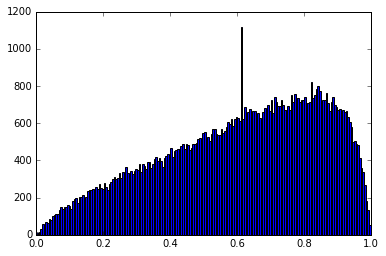

In [113]:
plt.hist(y_pred[:,1], bins=200)

In [18]:
###Roc_AUc

In [125]:
print(classification_report(y_sex_test, np.round(y_pred[:,1])))

             precision    recall  f1-score   support

        0.0       0.71      0.58      0.64     36538
        1.0       0.76      0.85      0.80     56507

avg / total       0.74      0.75      0.74     93045



In [126]:
roc_auc_score(y_sex_test, y_pred[:,1])

0.8033842253356418

In [151]:
X_sex_test[y_sex_test != (y_pred[:,1] > 0.5)]

uid
114340.0    ботанический аномалия заповедник галичий гора ...
275151.0    работа брянск определённый навык вакансия moya...
288359.0    штраф нарушение пожарный безопасность. штраф н...
67901.0     втб онлайн рамблер поиск. втб онлайн рамблер п...
324718.0    вакансия компания дикси группа компания работа...
225711.0    песок прокомментировать сообщение возможный от...
372811.0    мистер макс стамбул парк аттракцион кататься м...
366433.0    ирина шейк стать лицо vogue fashion s night ou...
102393.0    марка infiniti показать мотор переменный степе...
315173.0    пляж местный гид город природа топ выбирать ру...
347623.0    детский задачка банан кокос разделить интернет...
279638.0    бадминтонист иванов созон сыграть четвертьфина...
14216.0     фина ru акция россеть ао котировка стоимость ц...
61805.0     путин отправить личный послание президент пале...
274464.0    век восхищение рамблер видео. красавица наталь...
230923.0    переводчик эстонский русский онлайн бесплатно....
1398

#### Вывод: Логистическая регрессия дает самое лучшее качество roc_auc = 0.805172205320138; среди всех линейных моделей

#### Сохраним нашу модель 

In [5]:
from sklearn.externals import joblib

In [35]:
filename = '/Volumes/TOSHIBA/Diplom/pipeline_tfid_log_model.sav'
joblib.dump(pipeline_tfid_log, filename)

['/Volumes/TOSHIBA/Diplom/pipeline_tfid_log_model.sav']

#### 3.2.2 Понижение размерности, построение случайного леса и градиентаного бустинга.

In [ ]:
pipeline_tfidf_svd_tree = Pipeline([
        ('vect', TfidfVectorizer(stop_words=freq_words, ngram_range=(1, 3))),###min_df=2, max_df=0.01, без stowords: 0.73279538452835213
        ('svd', TruncatedSVD(n_components=100)),
        ('clf', ExtraTreesClassifier(n_estimators=100))
    ])

In [ ]:
cross_val_score(pipeline_tfidf_svd_tree, X_sex_train, y_sex_train, scoring="roc_auc", cv=3).mean()

In [ ]:
###0.73279538452835213

#### 3.2.3 Word2Vec, построение случайного леса и градиентаного бустинга.

#### 3.2.3.1 Подготовка данных

In [12]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def word2vec_format(X):
    result = []
    for i in X.iteritems():
        sentences = []
        for token in i[1].split():
            sentences.append(token)
        result.append(sentences)
    return result

In [13]:
trainSexDataVecs = word2vec_format(df.title)

In [14]:
modelSex = word2vec.Word2Vec(trainSexDataVecs, size=100, window=5, min_count=5, workers=2)

In [15]:
modelSex.save("/Volumes/TOSHIBA/Diplom/word2vec_feauters_socdem")

In [32]:
w2vSex = {w: vec for w, vec in zip(modelSex.wv.index2word, modelSex.wv.syn0)}

#### 3.2.3.2 Создание W2V векторизатор

In [33]:
class MeanEmbeddingVectorizer(BaseEstimator):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = list(word2vec.values())[0].shape[0]

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [34]:
class TfidfEmbeddingVectorizer(BaseEstimator):
    def __init__(self, word2vec, freq_words=None):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = list(word2vec.values())[0].shape[0]
        self.freq_words = freq_words

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x, stop_words=self.freq_words, ngram_range=(1, 3))
        tfidf.fit(X)
        
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

#### 3.2.3.3 Обучение Word2Vec

In [47]:
pipeline_sex_word2vec_tree = Pipeline([
    ("vec", TfidfEmbeddingVectorizer(w2vSex, freq_words)),
    ("clf", ExtraTreesClassifier(n_estimators=100))])

In [53]:
cross_val_score(pipeline_sex_word2vec_tree, X_sex_train, y_sex_train, scoring='roc_auc', cv=3).mean()

0.6024868650470202

#### 3.2.4 Doc2Vec

In [32]:
def labelizeUserReviews(user_data):
    labelized = []
    for uid, title in user_data.iteritems():
        label = 'USER_ID_%s'%(uid)
        labelized.append(LabeledSentence(title.split(), [label]))
    return labelized

In [33]:
def getVecs(model, corpus, size):
    vecs = [np.array(model.docvecs[z.tags[0]]).reshape((1, size)) for z in corpus]
    return np.concatenate(vecs)

In [34]:
sentences = labelizeUserReviews(X_sex_train.append(X_sex_test))

In [35]:
len(sentences)

28195

In [36]:
size = 400

#instantiate our DM and DBOW models
model_dm = gensim.models.Doc2Vec(min_count=1, window=10, size=size, sample=1e-3, negative=5, workers=3)
model_dbow = gensim.models.Doc2Vec(min_count=1, window=10, size=size, sample=1e-3, negative=5, dm=0, workers=3)

In [37]:
model_dm.build_vocab(sentences)
model_dbow.build_vocab(sentences)

model_dm.train(sentences, total_examples=model_dm.corpus_count, end_alpha=0.005, epochs=10)
model_dbow.train(sentences, total_examples=model_dm.corpus_count, end_alpha=0.005, epochs=10)

47628139

In [ ]:
model_dm.save("/Volumes/TOSHIBA/Diplom/doc2vec_model_dm.sav")
model_dbow.save("/Volumes/TOSHIBA/Diplom/doc2vec_model_dbow.sav")

In [34]:
model_dm = Doc2Vec.load("/Volumes/TOSHIBA/Diplom/doc2vec_model_dm.sav") 
model_dbow = Doc2Vec.load("/Volumes/TOSHIBA/Diplom/doc2vec_model_dbow.sav")

In [51]:
X_sex_train_labelized = labelizeUserReviews(X_sex_train)
X_sex_test_labelized = labelizeUserReviews(X_sex_test)

In [52]:
train_vecs_dm = getVecs(model_dm, X_sex_train_labelized, size)
train_vecs_dbow = getVecs(model_dbow, X_sex_train_labelized, size)
train_vecs = np.hstack((train_vecs_dm, train_vecs_dbow))

In [53]:
test_vecs_dm = getVecs(model_dm, X_sex_test_labelized, size)
test_vecs_dbow = getVecs(model_dbow, X_sex_test_labelized, size)
test_vecs = np.hstack((test_vecs_dm, test_vecs_dbow))

In [42]:
sex_doc2vec_tree = ExtraTreesClassifier(n_estimators=1200)

In [88]:
cross_val_score(sex_doc2vec_tree, train_vecs, y_sex_train, scoring='roc_auc', cv=3).mean()

0.78987634006380558

In [91]:
sex_doc2vec_tree.fit(train_vecs, y_sex_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1200, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [92]:
accuracy_score(y_sex_test, sex_doc2vec_tree.predict(test_vecs))

0.74164427727028481

### Подбор гиперпараметров параметров

In [71]:
for x in range(116, 150):
    print(x, (3*116 + 2*x)/5)

116 116.0
117 116.4
118 116.8
119 117.2
120 117.6
121 118.0
122 118.4
123 118.8
124 119.2
125 119.6
126 120.0
127 120.4
128 120.8
129 121.2
130 121.6
131 122.0
132 122.4
133 122.8
134 123.2
135 123.6
136 124.0
137 124.4
138 124.8
139 125.2
140 125.6
141 126.0
142 126.4
143 126.8
144 127.2
145 127.6
146 128.0
147 128.4
148 128.8
149 129.2


In [52]:
clf = ExtraTreesClassifier()

param_grid_doc2vec_tree = { 
    'n_estimators': [700, 900, 1200]
}

In [53]:
grid_doc2vec_tree = GridSearchCV(clf, param_grid_doc2vec_tree, scoring="roc_auc", cv=3)
grid_doc2vec_tree.fit(train_vecs, y_sex_train)
print(grid_doc2vec_tree.best_params_)
print(grid_doc2vec_tree.best_score_)

{'n_estimators': 1200}
0.7938155517011887


### Конкатенация призназков TF-IDF и doc2vec

In [57]:
train_vecs_df = pd.DataFrame(train_vecs)
test_vecs_df = pd.DataFrame(test_vecs)

In [58]:
train_vecs_df.to_csv("train_doc2vec")
test_vecs_df.to_csv("test_doc2vec")

In [62]:
vec_sex_train = vectorizer.transform(X_sex_train)
vec_sex_test = vectorizer.transform(X_sex_test)

In [68]:
train_tfidf_df = pd.DataFrame(vec_sex_train.toarray())
test_tfidf_df = pd.DataFrame(vec_sex_test.toarray())

In [154]:
vec_sex_train_df = pd.DataFrame(data=vec_sex_train.toarray())

In [ ]:
train_sex_vec_concat = pd.concat([vec_sex_train_df,train_vecs_df], axis=1)

In [ ]:
train_sex_vec_concat = np.concatenate((vec_sex_train.toarray(), train_vecs), axis=1)

In [28]:
log_clf = LogisticRegression(C=1, penalty='l2')

In [ ]:
log_clf.fit()

#### 3.2.5 XGBoost и Doc2Vec

In [93]:
pipeline_sex_meanvect_xgboost = Pipeline([
        ('vect', TfidfVectorizer(stop_words=freq_words, ngram_range=(1, 3))),
        ('svd', TruncatedSVD(n_components=100)),
    ("clf", xgb.XGBClassifier())])

In [95]:
pipeline_sex_meanvect_xgboost.fit(X_sex_train, y_sex_train)

Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
  ...logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))])

In [100]:
cross_val_score(pipeline_sex_meanvect_xgboost, X_sex_train, y_sex_train, scoring='roc_auc', cv=3).mean()

0.75800995702754681

In [57]:
pipeline_sex_w2v_xgboost = Pipeline([
        ("vec", TfidfEmbeddingVectorizer(w2vSex, freq_words)),
    ("clf", xgb.XGBClassifier())])

In [58]:
cross_val_score(pipeline_sex_w2v_xgboost, X_sex_train, y_sex_train, scoring='roc_auc', cv=3).mean()

0.61207979302000093

#### 3.5. Использование композицию алгоритмов

In [100]:
y_pred1 = sex_doc2vec_tree.predict(test_vecs)
y_pred2 = pipeline_sex_meanvect_xgboost.predict(X_sex_test)
y_pred3 = pipeline_tfid_log.predict(X_sex_test)

In [110]:
y_pred3.shape

(9305,)

In [119]:
percentile_list = pd.DataFrame(
    {'col1': y_pred1,
     'col2': y_pred2,
     'col3': y_pred3,
    })

In [138]:
def voting_func(row):
    sum_row = np.sum(row)
    if sum_row == 2 or sum_row == 3:
        return 1
    return 0

In [139]:
accuracy_score(y_sex_test,percentile_list.apply(voting_func, axis=1))

0.73852767329392799

#### 3.6 RusVecotres

In [144]:
model = word2vec.KeyedVectors.load_word2vec_format("/Users/anton/Documents/news_0_300_2.bin", binary=True)

In [156]:
m2vRusVectores = {w: vec for w, vec in zip(list(map(lambda x: x.split("_")[0], model.index2word)), model.syn0)}

In [159]:
pipeline_w2v_tfidf_rusvect = Pipeline([
    ("vec", TfidfEmbeddingVectorizer(m2vRusVectores)),
    ("clf", ExtraTreesClassifier(n_estimators=100))])

In [160]:
cross_val_score(pipeline_w2v_tfidf_rusvect, X_sex_train, y_sex_train, scoring='roc_auc', cv=3).mean()

0.64499396149427957

In [161]:
model = word2vec.KeyedVectors.load("/Users/anton/ML/ml_course/Rambler/word2vec_feauters_sex")
m2vRusVectores = {w: vec for w, vec in zip(list(map(lambda x: x.split("_")[0], model.index2word)), model.syn0)}
pipeline_w2v_tfidf_rusvect = Pipeline([
    ("vec", TfidfEmbeddingVectorizer(m2vRusVectores)),
    ("clf", ExtraTreesClassifier(n_estimators=100))])

In [165]:
cross_val_score(pipeline_w2v_tfidf_rusvect, X_sex_train, y_sex_train, scoring='roc_auc', cv=3).mean()

0.60009230820257986

#### 3.3 Определение возраста

#### Возраст разбит на 7 интервалов возрастов. Отчет ведется от наименьшего из интервалов(1) до наибольшего (7).

#### Построим многоклассовую классификацию с использованием линейных моделей. 

In [29]:
adata = shuffle_data.head(int(shuffle_data.shape[0]))

In [30]:
X_age_train, X_age_test, y_age_train, y_age_test = train_test_split(adata.title, adata.age, test_size=0.33)###!!!стратифицировать выборку!!!

In [72]:
pipeline_age_tfidf_linear_reg = Pipeline([
        ('vect', TfidfVectorizer(stop_words=freq_words, ngram_range=(1, 3))),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

pipeline_age_tfidf_linear_reg.fit(X_age_train, y_age_train)
show_multiply_metrics(y_age_test, pipeline_age_tfidf_linear_reg.predict(X_age_test))

             precision    recall  f1-score   support

        1.0       0.00      0.00      0.00       224
        2.0       0.25      0.01      0.01       772
        3.0       0.36      0.75      0.49      2882
        4.0       0.30      0.33      0.31      2492
        5.0       0.29      0.11      0.16      1704
        6.0       0.35      0.02      0.03       908
        7.0       0.00      0.00      0.00       323

avg / total       0.30      0.34      0.27      9305

Accuracy 0.341536808168


//anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
def show_multiply_metrics(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    print("Accuracy", accuracy_score(y_true, y_pred))

#### Из предыдущего примера, видим что наше качество не отличается от наугад выбранного возраста. Объединеним возраст по группам — (1, 2), (3, 4) и (5, 6, 7).

In [31]:
def changeAgeGroup(sdata):
    sdata.loc[((sdata.age == 1) | (sdata.age == 2)), 'age'] = 1
    sdata.loc[((sdata.age == 3) | (sdata.age == 4)), 'age'] = 2
    sdata.loc[((sdata.age == 5) | (sdata.age == 6) | (sdata.age == 7)), 'age'] = 3
    return sdata

In [32]:
age_data = changeAgeGroup(shuffle_data.copy())

In [33]:
age_data.age.value_counts()

2.0    165408
3.0     87844
1.0     28702
Name: age, dtype: int64

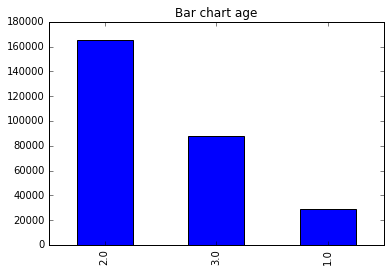

In [79]:
age_data.age.value_counts().plot(kind='bar', title="Bar chart age")

In [80]:
"{0:2f}%".format(age_data.age.value_counts().min() / age_data.age.value_counts().max() * 100)

'17.352244%'

#### Построим линейные классфикаторы. 

In [34]:
adata = age_data.head(int(age_data.shape[0]))

In [35]:
X_age_train, X_age_test, y_age_train, y_age_test = train_test_split(adata.title, adata.age, test_size=0.33, stratify=adata.age)

In [ ]:
for clf in [LogisticRegression, LinearSVC, SGDClassifier]:
    pipeline_tfid_liner = Pipeline([
        ('vect', TfidfVectorizer(stop_words=freq_words, ngram_range=(1, 3))),
        ('clf', OneVsRestClassifier(clf()))
    ])
    print(clf)
    pipeline_tfid_liner.fit(X_age_train, y_age_train)
    show_multiply_metrics(y_age_test, pipeline_tfid_liner.predict(X_age_test))

<class 'sklearn.linear_model.logistic.LogisticRegression'>


#### Подберем гиперпараметры

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
pipeline_age_tfid_onevsclassifier_liner = Pipeline([
        ('vect', TfidfVectorizer(stop_words=freq_words, ngram_range=(1, 3))),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

parameters = {
    'clf__estimator__C': (0.01, 1, 10),
    'clf__estimator__penalty': ('l1', 'l2')
}

grid_pipeline_tfidf_svc = GridSearchCV(pipeline_age_tfid_onevsclassifier_liner, parameters)
grid_pipeline_tfidf_svc.fit(X_age_train, y_age_train)
print(grid_pipeline_tfidf_svc.best_params_)
print(grid_pipeline_tfidf_svc.best_score_)

In [ ]:
pipeline_age_tfidf_linear_reg = Pipeline([
        ('vect', TfidfVectorizer(stop_words=freq_words, ngram_range=(1, 3))),
        ('clf', OneVsOneClassifier(LogisticRegression(C=1, penalty='l2')))
    ])


pipeline_age_tfidf_linear_reg.fit(X_age_train, y_age_train)

Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
  ...=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1))])

In [194]:
print(classification_report(y_age_test, pipeline_age_tfidf_linear_reg.predict(X_age_test)))

             precision    recall  f1-score   support

        1.0       0.40      0.00      0.00       936
        2.0       0.62      0.94      0.74      5415
        3.0       0.63      0.22      0.33      2954

avg / total       0.60      0.62      0.54      9305



In [ ]:
from sklearn.externals import joblib
filename = '/Volumes/TOSHIBA/Diplom/pipeline_tfid_log_model_age.sav'
joblib.dump(pipeline_age_tfidf_linear_reg, filename)§

In [ ]:
joblib.load('/Volumes/TOSHIBA/Diplom/pipeline_tfid_log_model_age.sav')

In [37]:
accuracy_score(y_age_test, pipeline_age_tfidf_linear_reg.predict(X_age_test))

0.64085120103175885

In [ ]:
### качество на всей выборки

In [196]:
pipeline_age_meanvect_xgboost = Pipeline([
        ('vect', TfidfVectorizer(stop_words=freq_words, ngram_range=(1, 3))),
        ('svd', TruncatedSVD(n_components=100)),
    ("clf", xgb.XGBClassifier())])

In [ ]:
pipeline_age_meanvect_xgboost.fit(X_age_train, y_age_train)

#### Doc2Vec и многоклассовая 

In [43]:
X_age_train_labelized = labelizeUserReviews(X_age_train)
X_age_test_labelized = labelizeUserReviews(X_age_test)

In [46]:
train_vecs_dm = getVecs(model_dm, X_age_train_labelized, size)
train_vecs_dbow = getVecs(model_dbow, X_age_train_labelized, size)
train_age_vecs = np.hstack((train_vecs_dm, train_vecs_dbow))

In [47]:
test_vecs_dm = getVecs(model_dm, X_age_test_labelized, size)
test_vecs_dbow = getVecs(model_dbow, X_age_test_labelized, size)
test_age_vecs = np.hstack((test_vecs_dm, test_vecs_dbow))

In [63]:
from sklearn.multiclass import OneVsRestClassifier

In [76]:
pipeline_age_doc2vec_onevsclassifier_liner = Pipeline([
        ('clf', OneVsRestClassifier(LogisticRegression(C=10, penalty='l2')))
    ])
pipeline_age_doc2vec_onevsclassifier_liner.fit(train_age_vecs, y_age_train)
accuracy_score(y_age_test, pipeline_age_doc2vec_onevsclassifier_liner.predict(test_age_vecs))

0.57119828049435784

In [ ]:
pipeline_age_doc2vec_onevsclassifier_liner = Pipeline([
        ('clf', OneVsRestClassifier(xgb.XGBClassifier()))
    ])
pipeline_age_doc2vec_onevsclassifier_liner.fit(train_age_vecs, y_age_train)
accuracy_score(y_age_test, pipeline_age_doc2vec_onevsclassifier_liner.predict(test_age_vecs))

In [77]:
from sklearn.ensemble import GradientBoostingClassifier

In [78]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(train_age_vecs, y_age_train)
clf.score(test_age_vecs, y_age_test)             

0.57302525523911874